# PinaColADA Phase 2 Notebook 

The Youniverse dataset consists of 3 main sub-datasets : the channel dataset, the video dataset and the timeseries data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
import matplotlib.dates as mdates
from matplotlib import dates
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from ThymeBoost import ThymeBoost as tb

### Importing data 

For this phase we only use the channels dataset and the timeseries dataset

In [2]:
channels = pd.read_csv('data/df_channels_en.tsv', sep = '\t')
channels['join_date']= pd.to_datetime(channels['join_date'])
channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [3]:
timeseries = pd.read_csv('data/df_timeseries_en.tsv', sep = '\t')
timeseries['datetime']= pd.to_datetime(timeseries['datetime'])
timeseries['delta_views'] = timeseries['delta_views'].round(decimals = 3)
timeseries['subs'] = timeseries['subs'].round(decimals = 3)
timeseries['delta_subs'] = timeseries['delta_subs'].round(decimals = 3)
timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000,650.222,0.000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111,1046.000,395.778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083,1501.500,455.500,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250,1750.000,248.500,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600,2008.300,258.300,6,0,0


### Channel data exploration

In [4]:
channels.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.364700e+05,136470.000000,1.364700e+05,136470.000000
mean,2.466022e+05,699.784231,3.570087e+05,7.349363
std,1.150096e+06,4524.980928,2.711139e+05,5.277328
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.888575e+04,70.000000,1.161305e+05,4.231500
50%,4.240000e+04,175.000000,3.015670e+05,6.444000
75%,1.370000e+05,443.000000,5.704942e+05,9.243500
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


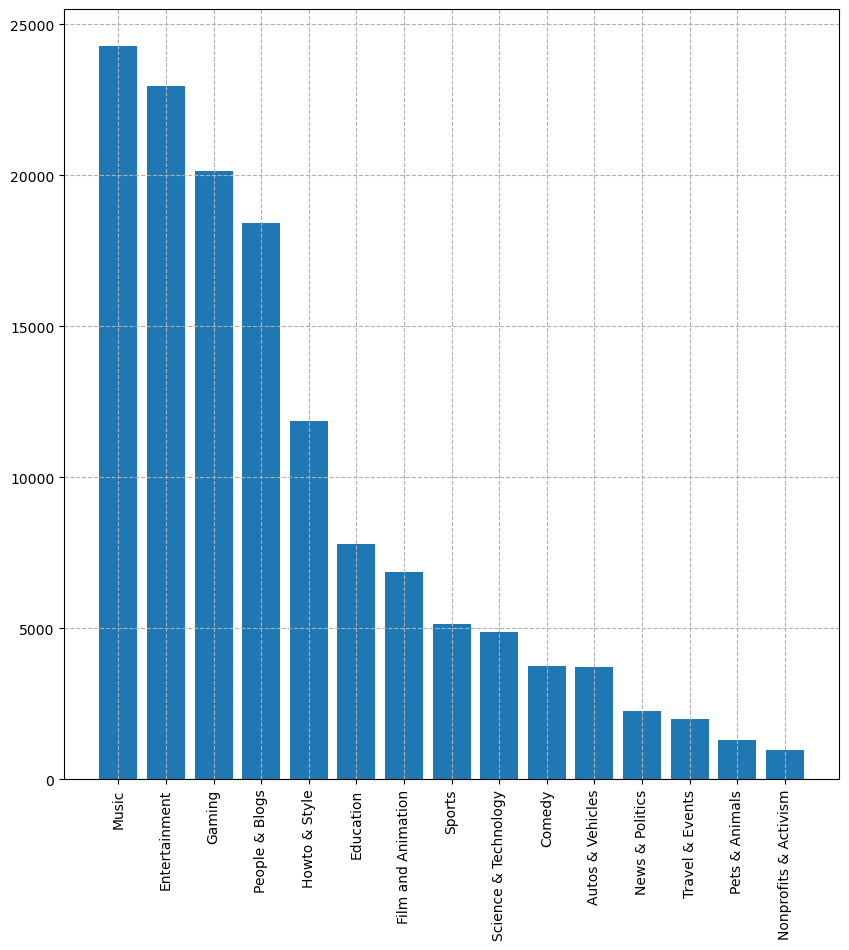

In [5]:
# Group the channels by categories
categories = channels.groupby(['category_cc']).size().to_frame()
categories.rename(columns={0:'count'}, inplace=True)

# Sort and plot the resulting data
categories.sort_values(by='count', ascending=False, inplace=True)
plt.figure(figsize=(10,10))
plt.grid(linestyle='--')
plt.bar(categories.index, categories['count'])
plt.xticks(rotation = 90)
plt.show()


We can see that there is a minority of categories that concentrate a large part of the channels: this can be explained by the fact that these are categories with much broader subjects than others (such as for example Entertainment compared to Pets & Animals) but also by the fact that some can be used by actors fondamentally different than typical Youtube content creators (like Music with artist channels).


In [6]:
# Power law definition : required for fitting the data
def power_law(x, a, k):
    return a * (x ** k)

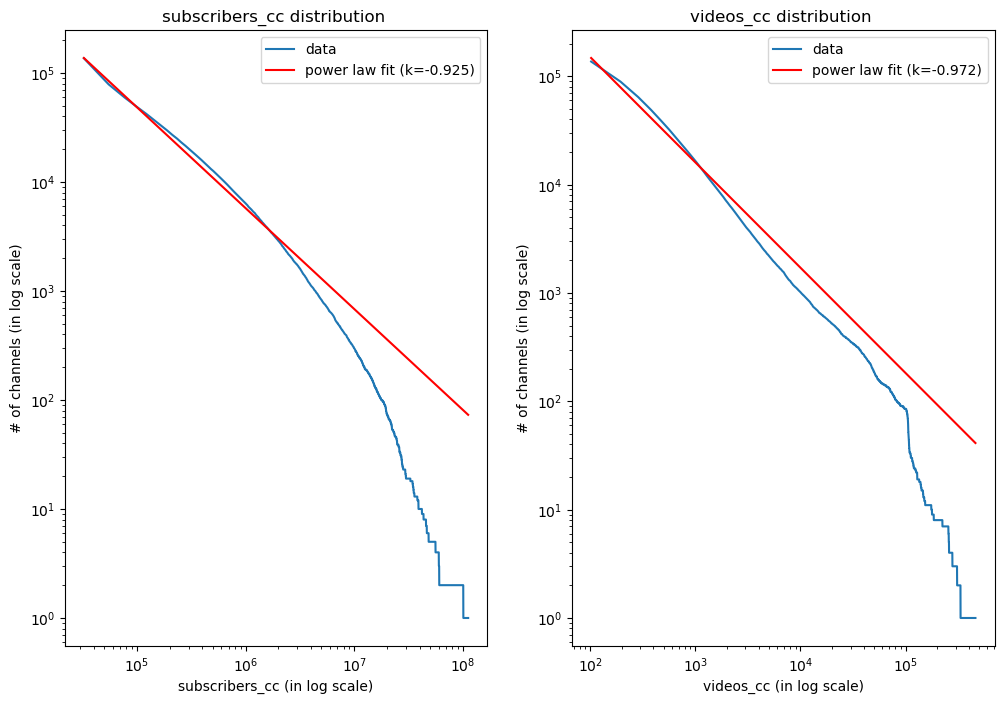

In [7]:
# For each category to plot :
power_law_cat = ['subscribers_cc', 'videos_cc']
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

for idx, cat in enumerate(power_law_cat):
    
    # Group the data into bins
    array_hist = ax[idx].hist(channels[cat], bins=5000,log=True,cumulative=-1,histtype='step')
    ax[idx].clear()
    
    # Fit the data to find a suitable power law
    popt, pcov = curve_fit(power_law,array_hist[1][1:],  array_hist[0])
    
    # Plot both the data and the fitted function
    ax[idx].loglog(array_hist[1][1:],array_hist[0], label='data')
    ax[idx].loglog(array_hist[1][1:], power_law(array_hist[1][1:], *popt), 'r-', label='power law fit (k=%.3f)' % tuple(popt)[1])
    ax[idx].set_title(f'{cat} distribution ')
    ax[idx].set_ylabel('# of channels (in log scale)')
    ax[idx].set_xlabel(f'{cat} (in log scale)')
    ax[idx].legend()

plt.show()
                                                                              

The subscribers count follows a power law : the vast majority of Youtube channels have a low number of subscribers while only a few channel concentrate the major part of subscriptions.
We can also make this statement about the number of published videos per channels

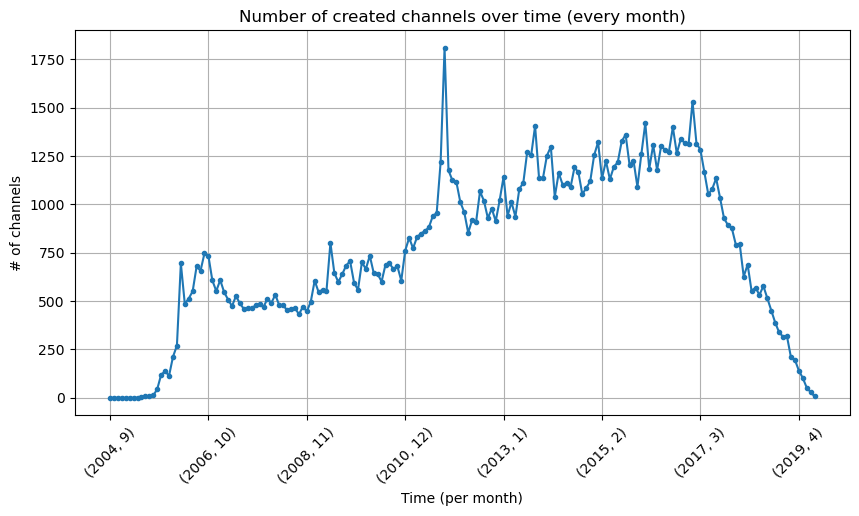

In [8]:
# Count the value of join_date 
creation_dt_df = channels['join_date'].value_counts().to_frame()

# Add missing values (if there was no channel created during a certain month we have to add 0-entry to our dataframe)
idx = pd.date_range(creation_dt_df.index.min(), creation_dt_df.index.max())
creation_dt_df.index = pd.DatetimeIndex(creation_dt_df.index)
creation_dt_df = creation_dt_df.reindex(idx, fill_value=0)

# Group the data by year and month to get an approrpiate scale
creation_dt_df = creation_dt_df.groupby([(creation_dt_df.index.year), (creation_dt_df.index.month)]).sum()

# Plot the final dataset 
creation_dt_df.plot(kind='line',figsize=(10,5), grid='--', legend=False, rot=45, marker=".")
plt.title('Number of created channels over time (every month)')
plt.ylabel('# of channels')
plt.xlabel('Time (per month)')
plt.show()

We can see that there is a considerable attraction for Youtube from its creation in 2005 and in the 2010s followed by a significant drop from 2017 where less and less channels are created.

In [9]:
datetimes = timeseries.groupby(pd.Grouper(key="datetime", freq="M")).channel.nunique()
channels_tot = len(timeseries.channel.unique())

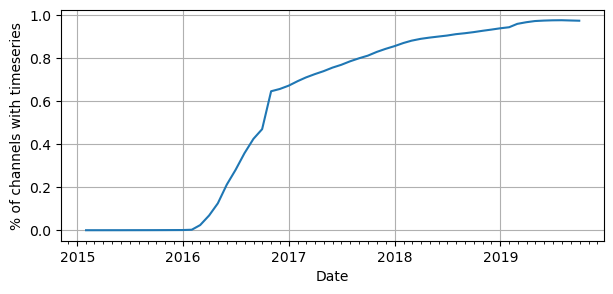

In [10]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(1, figsize=(7,3), sharey=True, sharex=True,
                       gridspec_kw={"wspace": 0.05})
# sns.lineplot(data=(datetimes / channels_tot), ax=ax)
ax.plot(datetimes / channels_tot)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlabel("Date")
ax.set_ylabel("% of channels with timeseries")
ax.grid()

From the graph above, we can see that there is relatively big expansion of the number of channels from 2016 to 2017 and grows slower after. From that we decide to pick only timeseries starting timestamp in January 2017. Also we decide to take channels that have at least 140 timestamps (which correspond to ~3 years)

In [11]:
timeseries = timeseries[timeseries.datetime > "2017-01-01"]
timeseries_sizes = timeseries.groupby('channel').size()
big_timeseries_sizes = timeseries_sizes[timeseries_sizes.values >= 140]
long_timeseries = timeseries[timeseries['channel'].isin(big_timeseries_sizes.index)]
long_timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
158,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-01-02,1.714010e+07,65566.375,7867.875,28.875,834,0,0
159,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-01-09,1.720997e+07,69870.625,7899.750,31.875,834,0,0
160,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-01-16,1.741332e+07,203352.375,7924.000,24.250,835,1,1
161,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-01-23,1.744436e+07,31039.125,7951.500,27.500,835,0,1
162,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-01-30,1.738996e+07,0.000,7982.000,30.500,835,0,0


### Distribution of the mean deltaviews

The plot consist of the number of channels that have the same delta views mean accross the time serie.

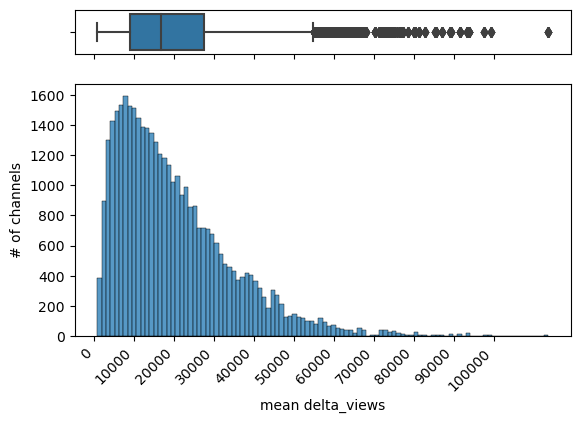

In [12]:
means = long_timeseries.groupby('channel')['delta_views'].mean().round(-1).astype(int)
vc = means.value_counts()[means.value_counts() > 6]
means = means[np.isin(means.values, (vc.index))]

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=means, ax=ax_box)
sns.histplot(x=means, ax=ax_hist)
ax_hist.set_xticks(range(0, 110000, 10000))
ax_box.set_xticks(range(0, 110000, 10000))
ax_hist.set_xlabel("mean delta_views")
ax_hist.set_ylabel("# of channels")
f.autofmt_xdate(rotation=45)

Most of the channels have delta_views's mean between 8k - 28k

### Linear Regression of delta views

Loop over all channels to compute the slope and intercept value used for the linear regression. All data are min-max normalize.

In [13]:
slopes = []
for name, channel_df in long_timeseries.groupby('channel'):
    dv = channel_df['delta_views']
    normalized_df=(dv-dv.min())/(dv.max() - dv.min())
    res = stats.linregress(range(len(channel_df)), normalized_df.values)
    slopes.append((name, res.slope, res.intercept))

Sort the list according to the slopes to see the downfall / rise of channels

In [14]:
slopes_sort = sorted(slopes, key=lambda x: x[1])

Text(0.5, 0.98, 'The most falling / stagning / rising channels')

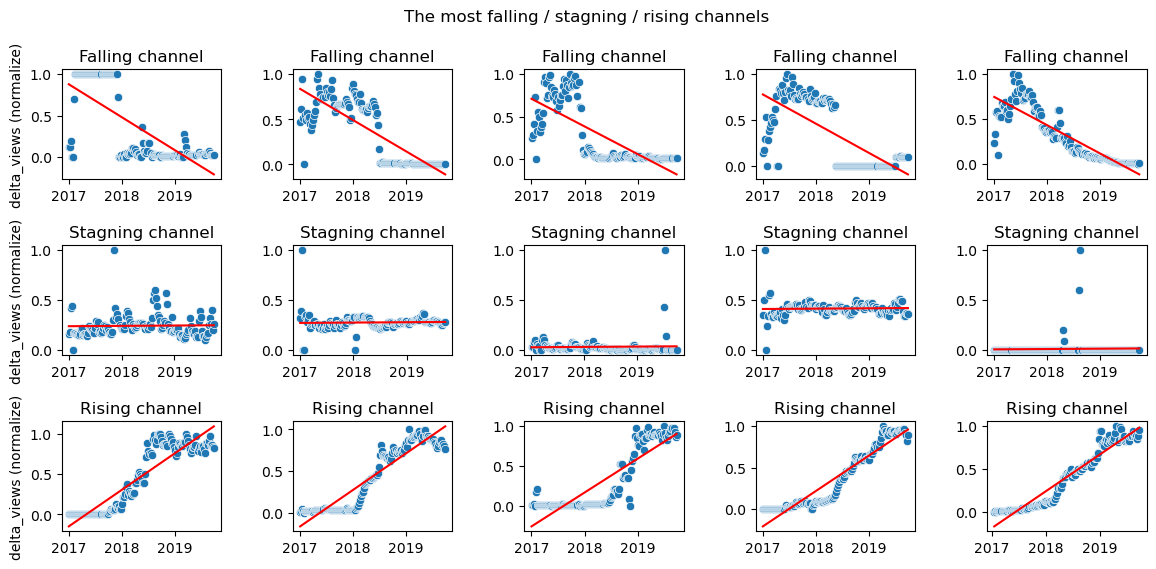

In [15]:
f, axs = plt.subplots(3, 5, figsize=(14, 6), gridspec_kw={"wspace": 0.45, "hspace": 0.6, 
                                      "height_ratios": [1, 1, 1]})

for i, ax in enumerate(axs[0]):
    idx = i
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Falling channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[1]):
    idx = i + int(len(slopes_sort) / 2)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")    
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Stagning channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[2]):
    idx = -(i + 1)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Rising channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

f.suptitle("The most falling / stagning / rising channels")

### Dealing with outliers

As we can see there clearly, there is some channels that, according to our regression, are stagning. But is it truly the case? Look for example the plot in the middle. (2nd row, 3rd collumn). There are some outliers that might influence the regression and hence show that the channel is stagning which is not necessarly the case. 

Let's deal with those outliers: detect them and do something with it.

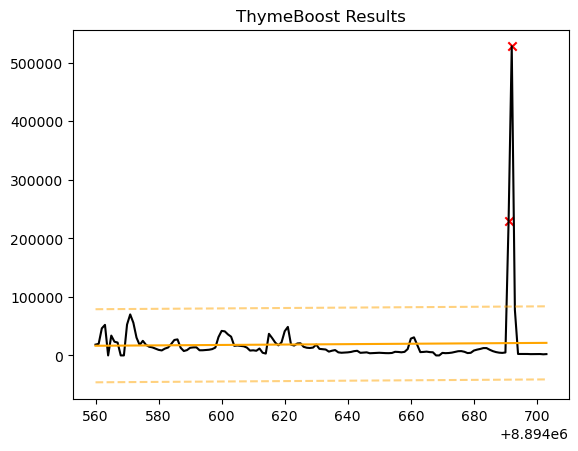

In [16]:
boosted_model = tb.ThymeBoost()
idx = int(len(slopes_sort) / 2) + 2
df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
output = boosted_model.detect_outliers(df['delta_views'],
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)

Here there are marked with a red X. We choose to set them to the mean value of the delta views.

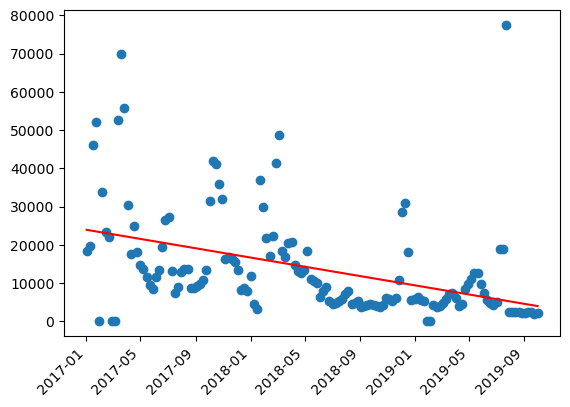

In [17]:
fig, ax = plt.subplots()
mean = output.y.mean()
output[output.outliers] = mean
res = stats.linregress(range(len(output)), output.y)
ax.scatter(df.datetime, output.y)
ax.plot(df.datetime, res.intercept + range(len(output)) * res.slope, color="red")
fig.autofmt_xdate(rotation=45)

Now we clearly see that the channel was falling in terms of delta views instead of stagning as previously.